In [12]:
!pip install matplotlib

In [17]:
# Cell 1: Imports and setup
from matplotlib import pyplot as plt
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

Matplotlib is building the font cache; this may take a moment.


In [4]:
# Cell 2: Configuration
opt = {
    "n_epochs": 200,
    "batch_size": 64,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,
    "n_cpu": 8,
    "latent_dim": 100,
    "img_size": 28,
    "channels": 1,
    "sample_interval": 400
}

print(opt)

img_shape = (opt["channels"], opt["img_size"], opt["img_size"])

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

{'n_epochs': 200, 'batch_size': 64, 'lr': 0.0002, 'b1': 0.5, 'b2': 0.999, 'n_cpu': 8, 'latent_dim': 100, 'img_size': 28, 'channels': 1, 'sample_interval': 400}
Using device: mps


# Generator Architecture

 - MLP with 4 linear layers, BatchNorm, LeakyReLU, and Tanh output
 - Tanh maps to [-1, 1], suitable for image data



In [5]:
# Cell 3: Generator class
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt["latent_dim"], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

# Discriminator Architecture

 - MLP with 3 linear layers, LeakyReLU, and Sigmoid output
 - Sigmoid maps to [0, 1], suitable for binary classification


In [6]:
# Cell 4: Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Loss function and model initialization

 - Binary Cross-Entropy Loss (BCELoss)
 - Optimizers: Adam with specified learning rate and betas
 - DataLoader: MNIST dataset with specified transformations
 - Training loop: Iterates over the dataset, computes losses, updates weights, and saves images at specified intervals


In [7]:
# Cell 5: Loss function and model initialization
adversarial_loss = torch.nn.BCELoss().to(device)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))

In [8]:
# Cell 6: Data loading
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt["img_size"]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt["batch_size"],
    shuffle=True,
    num_workers=opt["n_cpu"],
    pin_memory=device.type != "cpu"
)

# Training loop

 - Iterates over the dataset
 - Computes losses for generator and discriminator
 - Updates weights of both models
 - Saves generated images at specified intervals


In [10]:
# Cell 7: Training loop
for epoch in range(opt["n_epochs"]):
    total_g_loss = 0
    total_d_loss = 0
    batches_done = 0
    
    for i, (imgs, _) in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, device=device)
        fake = torch.zeros(imgs.size(0), 1, device=device)

        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.randn(imgs.shape[0], opt["latent_dim"], device=device)

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        # )

        total_g_loss += g_loss.item()
        total_d_loss += d_loss.item()
        batches_done += 1

        if batches_done % opt["sample_interval"] == 0:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )
            save_image(gen_imgs.data[:25], f"images/{batches_done}.png", nrow=5, normalize=True)

    # Print epoch summary
    avg_g_loss = total_g_loss / len(dataloader)
    avg_d_loss = total_d_loss / len(dataloader)
    print(f"[Epoch {epoch+1}/{opt['n_epochs']}] [Avg D loss: {avg_d_loss:.4f}] [Avg G loss: {avg_g_loss:.4f}]")

[Epoch 1/200] [Avg D loss: 0.3577] [Avg G loss: 1.7473]
[Epoch 2/200] [Avg D loss: 0.3224] [Avg G loss: 1.9883]
[Epoch 3/200] [Avg D loss: 0.3032] [Avg G loss: 2.1302]
[Epoch 4/200] [Avg D loss: 0.2861] [Avg G loss: 2.2050]
[Epoch 5/200] [Avg D loss: 0.2864] [Avg G loss: 2.2751]
[Epoch 6/200] [Avg D loss: 0.2729] [Avg G loss: 2.3394]
[Epoch 7/200] [Avg D loss: 0.2534] [Avg G loss: 2.5065]
[Epoch 8/200] [Avg D loss: 0.2674] [Avg G loss: 2.4871]
[Epoch 9/200] [Avg D loss: 0.2325] [Avg G loss: 2.7350]
[Epoch 10/200] [Avg D loss: 0.2484] [Avg G loss: 2.6308]
[Epoch 11/200] [Avg D loss: 0.2377] [Avg G loss: 2.7857]
[Epoch 12/200] [Avg D loss: 0.2484] [Avg G loss: 2.6751]
[Epoch 13/200] [Avg D loss: 0.2189] [Avg G loss: 2.8781]
[Epoch 14/200] [Avg D loss: 0.2424] [Avg G loss: 2.7292]
[Epoch 15/200] [Avg D loss: 0.2072] [Avg G loss: 2.7994]
[Epoch 16/200] [Avg D loss: 0.1960] [Avg G loss: 3.1026]
[Epoch 17/200] [Avg D loss: 0.2069] [Avg G loss: 3.1027]
[Epoch 18/200] [Avg D loss: 0.2092] [Avg

# Generate and display images
 - Generates images using the trained generator
 - Displays the generated images in a nxn grid

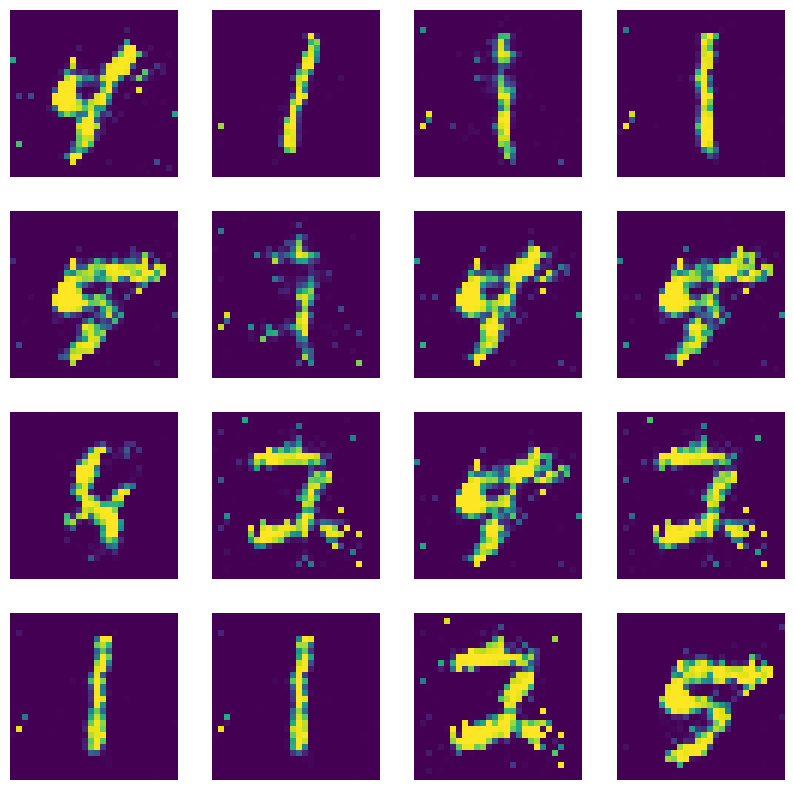

In [19]:
def generate_and_display_images(generator, num_images=16, latent_dim=100, device='cuda'):
    """
    Generate images using the GAN and display them in the notebook.
    
    Args:
    generator (nn.Module): The trained generator model
    num_images (int): Number of images to generate
    latent_dim (int): Dimension of the latent space
    device (str): Device to run the model on ('cuda' or 'cpu')
    """
    # Set the generator to evaluation mode
    generator.eval()
    
    # Generate random noise
    z = torch.randn(num_images, latent_dim, device=device)
    
    # Generate images
    with torch.no_grad():
        gen_imgs = generator(z)
    
    # Move images to CPU and convert to numpy arrays
    gen_imgs = gen_imgs.cpu().numpy()
    
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Plot the generated images
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(gen_imgs[cnt].transpose(1, 2, 0))
            axs[i,j].axis('off')
            cnt += 1
    plt.show()

# Example usage:
generate_and_display_images(generator, num_images=16, latent_dim=opt["latent_dim"], device=device)


# Save and load the GAN model
 - Save the GAN model, including the generator, discriminator, and optimizers
 - Load the GAN model from a file
 - Display the generated images

/var/folders/jk/dyw0vdnx2jg9lyq8m01n8nfm0000gn/T/ipykernel_33369/3527324264.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, map_locati

GAN model loaded from gan_model.pth


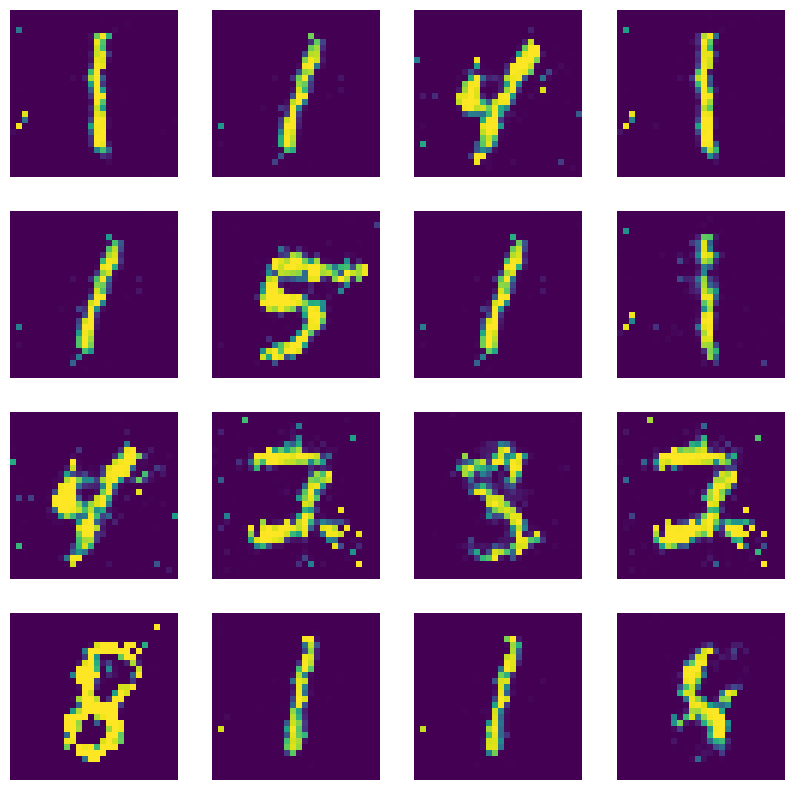

In [29]:
import torch

def save_gan(generator, discriminator, optimizer_G, optimizer_D, epoch, filename):
    """
    Save the GAN model, including the generator, discriminator, and optimizers.
    
    Args:
    generator (nn.Module): The generator model
    discriminator (nn.Module): The discriminator model
    optimizer_G (torch.optim.Optimizer): The generator's optimizer
    optimizer_D (torch.optim.Optimizer): The discriminator's optimizer
    epoch (int): The current epoch number
    filename (str): The filename to save the model to
    """
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, filename)
    print(f"GAN model saved to {filename}")

def load_gan(generator, discriminator, optimizer_G, optimizer_D, filename, device):
    """
    Load a saved GAN model.
    
    Args:
    generator (nn.Module): The generator model architecture
    discriminator (nn.Module): The discriminator model architecture
    optimizer_G (torch.optim.Optimizer): The generator's optimizer
    optimizer_D (torch.optim.Optimizer): The discriminator's optimizer
    filename (str): The filename to load the model from
    device (str): The device to load the model to ('cuda' or 'cpu')
    
    Returns:
    tuple: (generator, discriminator, optimizer_G, optimizer_D, epoch)
    """
    checkpoint = torch.load(filename, map_location=device)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    epoch = checkpoint['epoch']
    print(f"GAN model loaded from {filename}")
    return generator, discriminator, optimizer_G, optimizer_D, epoch

# Example usage:
# save_gan(generator, discriminator, optimizer_G, optimizer_D, 200, 'gan_model.pth')
generator, discriminator, optimizer_G, optimizer_D, epoch = load_gan(generator, discriminator, optimizer_G, optimizer_D, 'gan_model.pth', device)

generate_and_display_images(generator, num_images=16, latent_dim=opt["latent_dim"], device=device)

